# Autoregulatory Mechanism Detection - Data Preparation

**Goal:** Prepare a labeled dataset to train ML models that identify autoregulatory mechanisms (autophosphorylation, autoubiquitination, etc.) in scientific papers.

## Setup

In [1]:
import pyreadr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from html import unescape

## Data Loading

In [2]:
# PubMed dataset loading
pubmed = pyreadr.read_r('data/raw/pubmed.rds')
pubmed_df = list(pubmed.values())[0]
pubmed_df.head()

,PMID,Title,Abstract,Journal,Authors
0,15165820,"Comparative genomic analyses of frog virus 3, ...",Frog virus 3 (FV3) is the type species member ...,Virology,"Wendy G H Tan, Todd J Barkman, V Gregory Chinc..."
1,16912294,Genome of invertebrate iridescent virus type 3...,Iridoviruses (IVs) are classified into five ge...,Journal of virology,"Gustavo Delhon, Edan R Tulman, Claudio L Afons..."
2,11448171,Analysis of the first complete DNA sequence of...,"Chilo iridescent virus (CIV), the type species...",Virology,"N J Jakob, K Müller, U Bahr, G Darai"
3,17239238,Comparative genomic analysis of the family Iri...,Members of the family Iridoviridae can cause s...,Virology journal,"Heather E Eaton, Julie Metcalf, Emily Penny, V..."
4,20633916,"Frog virus 3 ORF 53R, a putative myristoylated...",Although previous work identified 12 complemen...,Virology,"Dexter S Whitley, Kwang Yu, Robert C Sample, A..."


In [3]:
# Autoregulatory database loading
autoreg = pyreadr.read_r('data/raw/autoregulatoryDB.rds')
autoreg_df = list(autoreg.values())[0]
autoreg_df.head()

,AC,OS,RN,RP,RC,RX,RG,RA,RT,RL,Term_in_RP,Term_in_RT,Term_in_RC
0,Q6GZX4,Frog virus 3 (isolate Goorha) (FV-3),[1],NUCLEOTIDE SEQUENCE [LARGE SCALE GENOMIC DNA].,NaN,PubMed=15165820; DOI=10.1016/j.virol.2004.02.019;,NaN,"Tan W.G., Barkman T.J., Gregory Chinchar V., E...","""Comparative genomic analyses of frog virus 3,...",Virology 323:70-84(2004).,,,
1,Q6GZX3,Frog virus 3 (isolate Goorha) (FV-3),[1],NUCLEOTIDE SEQUENCE [LARGE SCALE GENOMIC DNA].,NaN,PubMed=15165820; DOI=10.1016/j.virol.2004.02.019;,NaN,"Tan W.G., Barkman T.J., Gregory Chinchar V., E...","""Comparative genomic analyses of frog virus 3,...",Virology 323:70-84(2004).,,,
2,Q197F8,Invertebrate iridescent virus 3 (IIV-3) (Mosqu...,[1],NUCLEOTIDE SEQUENCE [LARGE SCALE GENOMIC DNA].,NaN,PubMed=16912294; DOI=10.1128/jvi.00464-06;,NaN,"Delhon G., Tulman E.R., Afonso C.L., Lu Z., Be...","""Genome of invertebrate iridescent virus type ...",J. Virol. 80:8439-8449(2006).,,,
3,Q197F7,Invertebrate iridescent virus 3 (IIV-3) (Mosqu...,[1],NUCLEOTIDE SEQUENCE [LARGE SCALE GENOMIC DNA].,NaN,PubMed=16912294; DOI=10.1128/jvi.00464-06;,NaN,"Delhon G., Tulman E.R., Afonso C.L., Lu Z., Be...","""Genome of invertebrate iridescent virus type ...",J. Virol. 80:8439-8449(2006).,,,
4,Q6GZX2,Frog virus 3 (isolate Goorha) (FV-3),[1],NUCLEOTIDE SEQUENCE [LARGE SCALE GENOMIC DNA].,NaN,PubMed=15165820; DOI=10.1016/j.virol.2004.02.019;,NaN,"Tan W.G., Barkman T.J., Gregory Chinchar V., E...","""Comparative genomic analyses of frog virus 3,...",Virology 323:70-84(2004).,,,


## Initial EDA

### PubMed

In [4]:
# Basic info
print(f"Shape: {pubmed_df.shape}")
print(f"Columns: {pubmed_df.columns.tolist()}")

Shape: (262819, 5)
Columns: ['PMID', 'Title', 'Abstract', 'Journal', 'Authors']


In [5]:
# Data types and missing values
print(pubmed_df.dtypes)
print(f"\nMissing values:\n{pubmed_df.isnull().sum()}")

PMID         int32
Title       object
Abstract    object
Journal     object
Authors     object
dtype: object

Missing values:
PMID           0
Title          0
Abstract    8607
Journal        0
Authors        0
dtype: int64


In [6]:
# Check for duplicate PMIDs
print(f"Duplicate PMIDs: {pubmed_df.duplicated('PMID').sum()}")

Duplicate PMIDs: 0


### Autoregulatory Database

In [7]:
# Basic info
print(f"Shape: {autoreg_df.shape}")
print(f"Columns: {autoreg_df.columns.tolist()}")

Shape: (1323976, 13)
Columns: ['AC', 'OS', 'RN', 'RP', 'RC', 'RX', 'RG', 'RA', 'RT', 'RL', 'Term_in_RP', 'Term_in_RT', 'Term_in_RC']


In [8]:
# Missing values
print(autoreg_df.isnull().sum())

AC                  0
OS                  0
RN                  0
RP                  0
RC             511667
RX             178720
RG            1210925
RA              68817
RT              56058
RL                  0
Term_in_RP          0
Term_in_RT          0
Term_in_RC          0
dtype: int64


## Data Preparation

In [9]:
# Extract PMID from RX column
autoreg_df['PMID'] = autoreg_df['RX'].str.extract(r'PubMed=(\d+)', expand=False)
autoreg_df['PMID'] = pd.to_numeric(autoreg_df['PMID'], errors='coerce')

In [10]:
# Check for duplicates
print(f"Duplicate PMIDs: {autoreg_df.duplicated('PMID', keep=False).sum()}")

Duplicate PMIDs: 1144977


In [11]:
# Merge terms from three columns into one
def merge_terms(row):
    cols = ['Term_in_RP', 'Term_in_RT', 'Term_in_RC']
    terms = []
    for col in cols:
        val = row[col]
        if pd.notna(val):
            terms.extend([t.strip() for t in str(val).split(',') if t.strip()])
    return ', '.join(sorted(set(terms))) if terms else ''

autoreg_df['Terms'] = autoreg_df.apply(merge_terms, axis=1)

In [12]:
# Check labeled vs unlabeled
labeled = (autoreg_df['Terms'] != '').sum()
print(f"Labeled: {labeled:,}, Unlabeled: {len(autoreg_df) - labeled:,}")

Labeled: 1,823, Unlabeled: 1,322,153


In [13]:
# Check how many labeled rows have missing PMID
missing_pmid_labeled = autoreg_df[(autoreg_df['PMID'].isna()) & (autoreg_df['Terms'] != '')].shape[0]
print(f"Labeled rows with missing PMID: {missing_pmid_labeled}")

Labeled rows with missing PMID: 10


In [14]:
# Drop rows with missing PMID
autoreg_df = autoreg_df.dropna(subset=['PMID'])
print(f"After dropping: {len(autoreg_df):,} rows")

After dropping: 1,142,197 rows


In [15]:
# Aggregate duplicates - combine all terms for the same PMID
autoreg_aggregated = (
    autoreg_df.groupby('PMID', as_index=False)
    .agg({
        'Terms': lambda x: ', '.join(sorted(set(
            term.strip()
            for terms_str in x
            for term in str(terms_str).split(',')
            if term.strip()
        )))
    })
)

autoreg_aggregated['has_mechanism'] = autoreg_aggregated['Terms'] != ''

In [16]:
# Summary
print(f"Before aggregation: {len(autoreg_df):,} rows")
print(f"After aggregation: {len(autoreg_aggregated):,} unique PMIDs")
print(f"Labeled: {autoreg_aggregated['has_mechanism'].sum():,}")

Before aggregation: 1,142,197 rows
After aggregation: 268,619 unique PMIDs
Labeled: 1,374


## Merging Datasets

In [17]:
# Ensure same data type for merging
pubmed_df['PMID'] = pubmed_df['PMID'].astype('int64')
autoreg_aggregated['PMID'] = autoreg_aggregated['PMID'].astype('int64')

In [18]:
# Left join - keep all PubMed papers, add labels where available
merged_df = pubmed_df.merge(
    autoreg_aggregated[['PMID', 'Terms', 'has_mechanism']],
    on='PMID',
    how='left'
)

# Fill missing values
merged_df['Terms'] = merged_df['Terms'].fillna('')
merged_df['has_mechanism'] = merged_df['has_mechanism'].fillna(False)

In [19]:
# Merge summary
print(f"Total papers: {len(merged_df):,}")
print(f"Labeled: {merged_df['has_mechanism'].sum():,}")
print(f"Unlabeled: {(~merged_df['has_mechanism']).sum():,}")

Total papers: 262,819
Labeled: 1,349
Unlabeled: 261,470


In [20]:
# Track label loss
labels_before = (autoreg_df['Terms'] != '').sum()
labels_after_agg = autoreg_aggregated['has_mechanism'].sum()
labels_after_merge = merged_df['has_mechanism'].sum()

print(f"\nLabel tracking:")
print(f"Original autoreg: {labels_before:,}")
print(f"After aggregation: {labels_after_agg:,}")
print(f"After merge: {labels_after_merge:,}")
print(f"Total lost: {labels_before - labels_after_merge:,}")


Label tracking:
Original autoreg: 1,813
After aggregation: 1,374
After merge: 1,349
Total lost: 464


In [21]:
# Check which labeled papers aren't in PubMed
autoreg_labeled = set(autoreg_aggregated[autoreg_aggregated['has_mechanism']]['PMID'])
pubmed_pmids = set(pubmed_df['PMID'])
missing = autoreg_labeled - pubmed_pmids

print(f"\nLabeled papers not in PubMed: {len(missing)}")


Labeled papers not in PubMed: 25


In [22]:
# Drop papers without abstracts
labeled_missing_abstract = merged_df[merged_df['has_mechanism'] & merged_df['Abstract'].isna()]
print(f"Labeled papers missing abstracts: {len(labeled_missing_abstract)}")

merged_df = merged_df[merged_df['Abstract'].notna()]
print(f"After dropping: {len(merged_df):,} papers, {merged_df['has_mechanism'].sum():,} labeled")

Labeled papers missing abstracts: 2
After dropping: 254,212 papers, 1,347 labeled


## Feature Engineering

In [23]:
# Combine title and abstract into single text field
merged_df['text'] = merged_df['Title'].fillna('') + '. ' + merged_df['Abstract'].fillna('')


In [24]:
def clean_text(text):
    if pd.isna(text):
        return ""
    
    text = str(text)
    text = unescape(text)               # Fix HTML entities like &amp;
    text = re.sub(r'http\S+', '', text) # Remove URLs
    text = re.sub(r'\S+@\S+', '', text) # Remove emails
    text = re.sub(r'\s+', ' ', text)    # Normalize whitespace
    
    return text.strip()

merged_df['text'] = merged_df['text'].apply(clean_text)
merged_df['text_length'] = merged_df['text'].str.len()

In [25]:
# Check for very short texts (potential data quality issues)
short_texts = merged_df[merged_df['text_length'] < 100]
print(f"\nPapers with <100 characters: {len(short_texts)}")
if len(short_texts) > 0:
    print("Example:")
    print(short_texts.iloc[0]['text'])


Papers with <100 characters: 2
Example:
Filamin C Cardiomyopathy Variants Cause Protein and Lysosome Accumulation.. [Figure: see text].


In [26]:
# Check if the short ones are labeled
short_labeled = short_texts[short_texts['has_mechanism']]
print(f"Short texts that are labeled: {len(short_labeled)}")

Short texts that are labeled: 0


In [27]:

# Text length statistics
print(f"Mean text length: {merged_df['text_length'].mean():.0f}")
print(f"Median text length: {merged_df['text_length'].median():.0f}")

Mean text length: 1348
Median text length: 1351


In [28]:
# Compare labeled vs unlabeled text lengths
labeled_lengths = merged_df[merged_df['has_mechanism']]['text_length']
unlabeled_lengths = merged_df[~merged_df['has_mechanism']]['text_length']

print(f"\nLabeled - Mean: {labeled_lengths.mean():.0f}, Median: {labeled_lengths.median():.0f}")
print(f"Unlabeled - Mean: {unlabeled_lengths.mean():.0f}, Median: {unlabeled_lengths.median():.0f}")


Labeled - Mean: 1403, Median: 1402
Unlabeled - Mean: 1348, Median: 1351


## Initial Term Analysis

In [29]:
# Extract all terms from labeled papers
all_terms = []
for terms_str in merged_df[merged_df['has_mechanism']]['Terms']:
    if pd.notna(terms_str) and terms_str != '':
        all_terms.extend([t.strip() for t in terms_str.split(',')])

term_counts = pd.Series(all_terms).value_counts()

In [30]:
# Distribution
print("Term distribution:")
print(term_counts)
print(f"\nTotal unique terms: {len(term_counts)}")
print(f"Imbalance: {term_counts.max()}:{term_counts.min()} ratio")

Term distribution:
autophosphorylation    719
autocatalytic          133
autoubiquitination     121
autoregulation         119
autoinhibition          84
autoregulatory          44
autoinhibitory          43
autolysis               41
autoinducer             31
autoactivation          17
autocatalysis           14
autoinduction            7
autokinase               5
autofeedback             2
autophosphatase          1
Name: count, dtype: int64

Total unique terms: 15
Imbalance: 719:1 ratio


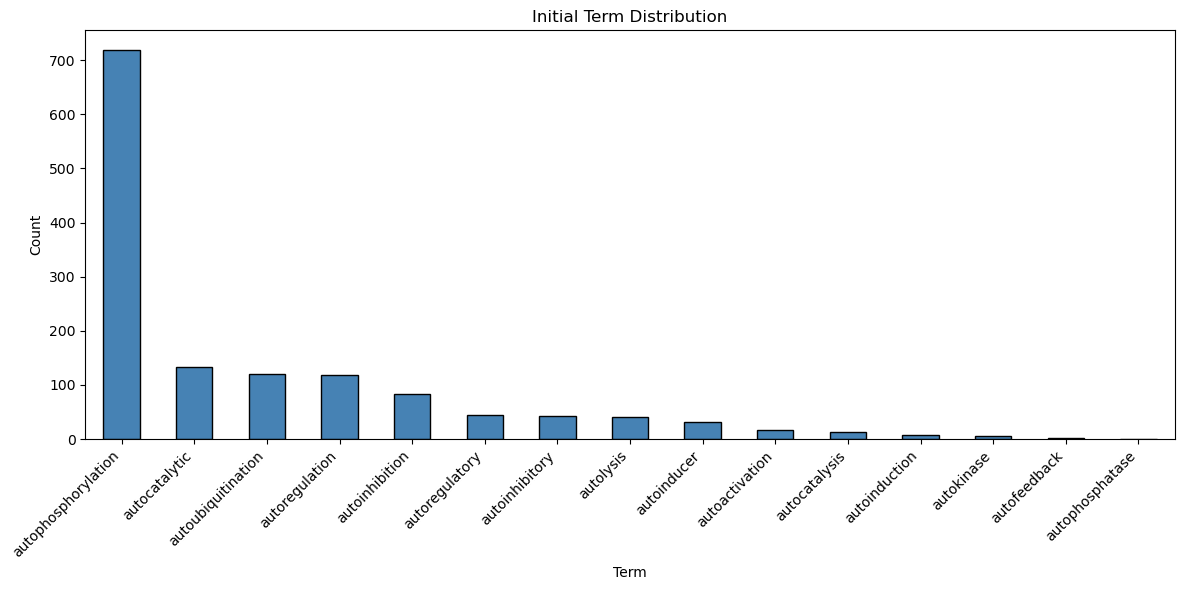

In [31]:
# Visualize
plt.figure(figsize=(12, 6))
term_counts.plot(kind='bar', color='steelblue', edgecolor='black')
plt.xlabel('Term')
plt.ylabel('Count')
plt.title('Initial Term Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Data Filtering & Normalization

In [32]:
# Normalize spelling variations to common forms
def normalize_terms(terms):
    if pd.isna(terms) or terms == '':
        return terms
    
    normalization_rules = {
        'autoregulatory': 'autoregulation',
        'autoinhibitory': 'autoinhibition',
        'autocatalysis': 'autocatalytic',
        'autoinduction': 'autoinducer',
        'autokinase': 'autophosphorylation',
        'autophosphatase': 'autophosphorylation',
    }
    
    normalized = []
    for term in terms.split(','):
        term = term.strip().lower()
        normalized.append(normalization_rules.get(term, term))
    
    return ', '.join(sorted(set(normalized)))

merged_df['Terms_normalized'] = merged_df['Terms'].apply(normalize_terms)
merged_df['has_mechanism_norm'] = (merged_df['Terms_normalized'] != '')

In [33]:
# Count normalized terms
all_norm_terms = []
for terms_str in merged_df[merged_df['has_mechanism_norm']]['Terms_normalized']:
    if pd.notna(terms_str) and terms_str != '':
        all_norm_terms.extend([t.strip() for t in terms_str.split(',')])

norm_counts = pd.Series(all_norm_terms).value_counts()
print("After normalization:")
print(norm_counts)

After normalization:
autophosphorylation    721
autoregulation         163
autocatalytic          147
autoinhibition         122
autoubiquitination     121
autolysis               41
autoinducer             38
autoactivation          17
autofeedback             2
Name: count, dtype: int64


In [34]:
# Keep only terms with enough examples
MIN_EXAMPLES = 35
keep_terms = norm_counts[norm_counts >= MIN_EXAMPLES].index.tolist()

print(f"\nKeeping {len(keep_terms)} terms with >={MIN_EXAMPLES} examples:")
print(norm_counts[norm_counts >= MIN_EXAMPLES])


Keeping 7 terms with >=35 examples:
autophosphorylation    721
autoregulation         163
autocatalytic          147
autoinhibition         122
autoubiquitination     121
autolysis               41
autoinducer             38
Name: count, dtype: int64


In [35]:
# Filter to kept terms only
def filter_to_kept_terms(terms_str):
    if pd.isna(terms_str) or terms_str == '':
        return ''
    terms = [t.strip() for t in terms_str.split(',')]
    kept = [t for t in terms if t in keep_terms]
    return ', '.join(sorted(set(kept)))

merged_df['Terms_final'] = merged_df['Terms_normalized'].apply(filter_to_kept_terms)
merged_df['has_mechanism_final'] = (merged_df['Terms_final'] != '')

In [36]:
# Remove papers that only had rare terms
df_final = merged_df[
    (~merged_df['has_mechanism_norm']) |
    (merged_df['has_mechanism_final'])
].copy()

print(f"\nFinal dataset: {len(df_final):,} papers ({df_final['has_mechanism_final'].sum():,} labeled)")


Final dataset: 254,199 papers (1,334 labeled)


## Term Analysis (Final)

In [37]:
# Count final terms after filtering
all_final_terms = []
for terms_str in df_final[df_final['has_mechanism_final']]['Terms_final']:
    if pd.notna(terms_str) and terms_str != '':
        all_final_terms.extend([t.strip() for t in terms_str.split(',')])

final_counts = pd.Series(all_final_terms).value_counts()

In [38]:
# Distribution
print("Final term distribution:")
print(final_counts)
print(f"\nKept {len(final_counts)} terms, imbalance {final_counts.max()}:{final_counts.min()} ratio")

Final term distribution:
autophosphorylation    721
autoregulation         163
autocatalytic          147
autoinhibition         122
autoubiquitination     121
autolysis               41
autoinducer             38
Name: count, dtype: int64

Kept 7 terms, imbalance 721:38 ratio


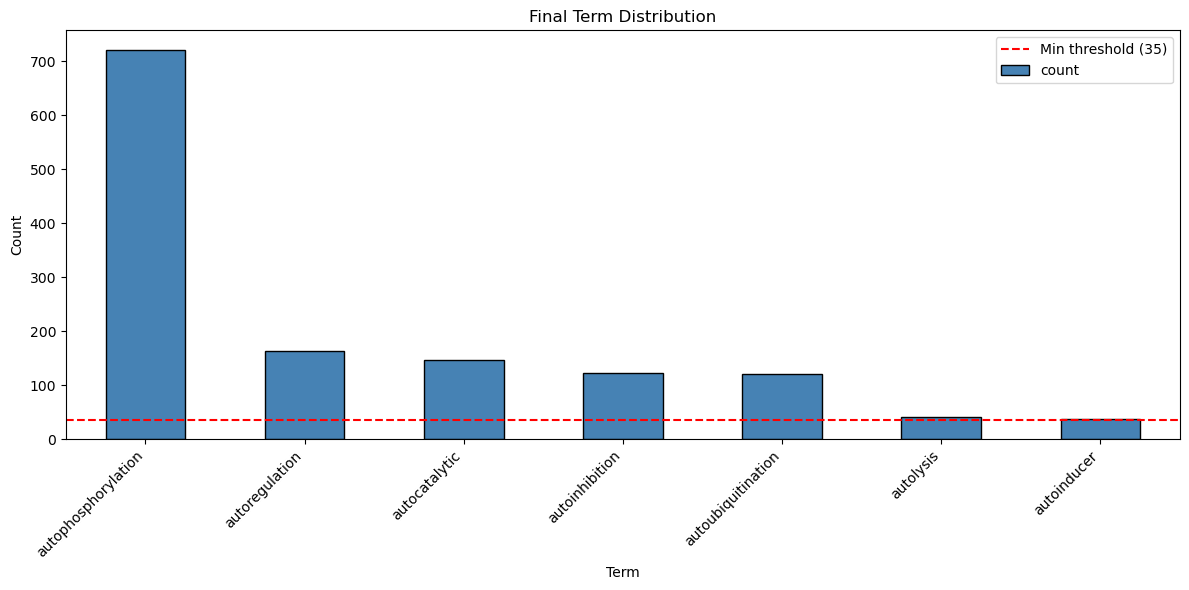

In [39]:
# Visualize
plt.figure(figsize=(12, 6))
final_counts.plot(kind='bar', color='steelblue', edgecolor='black')
plt.xlabel('Term')
plt.ylabel('Count')
plt.title('Final Term Distribution')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=MIN_EXAMPLES, color='red', linestyle='--', label=f'Min threshold ({MIN_EXAMPLES})')
plt.legend()
plt.tight_layout()
plt.show()

In [40]:
# Check if terms appear literally in text
print("\nKeyword presence analysis:")
for term in final_counts.index:
    papers_with_term = df_final[df_final['Terms_final'].str.contains(term, case=False, na=False, regex=False)]
    contains_literal = papers_with_term['text'].str.lower().str.contains(term.lower(), na=False, regex=False).sum()
    percentage = (contains_literal / len(papers_with_term)) * 100
    print(f"{term:20} {contains_literal:3}/{len(papers_with_term):3} ({percentage:5.1f}%)")


Keyword presence analysis:
autophosphorylation  341/721 ( 47.3%)
autoregulation       110/163 ( 67.5%)
autocatalytic         59/147 ( 40.1%)
autoinhibition        87/122 ( 71.3%)
autoubiquitination    17/121 ( 14.0%)
autolysis             40/ 41 ( 97.6%)
autoinducer           34/ 38 ( 89.5%)


In [41]:
# Show examples where term doesn't appear literally (hardest case)
autoub_papers = df_final[df_final['Terms_final'].str.contains('autoubiquitination', case=False, na=False, regex=False)]
autoub_without_keyword = autoub_papers[~autoub_papers['text'].str.lower().str.contains('autoubiquitination', na=False, regex=False)]

print(f"\nAutoubiquitination papers without literal term: {len(autoub_without_keyword)}\n")

for i, (idx, row) in enumerate(autoub_without_keyword.head(3).iterrows()):
    print(f"Example {i+1} - PMID {row['PMID']}:")
    print(f"Title: {row['Title'][:100]}...")
    print(f"Abstract: {str(row['Abstract'])[:200]}...\n")


Autoubiquitination papers without literal term: 104

Example 1 - PMID 18382127:
Title: CARPs enhance p53 turnover by degrading 14-3-3sigma and stabilizing MDM2....
Abstract: CARP1 and CARP2 proteins (CARPs) are E3 ligases that target p53 as well as phospho-p53 for degradation. Because MDM2 is a critical regulator of p53 turnover, we investigated and found that CARPs assoc...

Example 2 - PMID 15998807:
Title: The AIP2 E3 ligase acts as a novel negative regulator of ABA signaling by promoting ABI3 degradation...
Abstract: The phytohormone abscisic acid (ABA) mediates many complex aspects of plant development including seed maturation, dormancy, and germination as well as root growth. The B3-domain transcription factor ...

Example 3 - PMID 22508726:
Title: The ubiquitin ligase mLin41 temporally promotes neural progenitor cell maintenance through FGF signa...
Abstract: How self-renewal versus differentiation of neural progenitor cells is temporally controlled during early development re

In [42]:
# Check for papers with multiple mechanisms
multi_term_papers = df_final[df_final['Terms_final'].str.contains(',', na=False)]
print(f"\nPapers with multiple mechanisms: {len(multi_term_papers)}")

# Show distribution of how many terms per paper
if len(multi_term_papers) > 0:
    term_counts_per_paper = multi_term_papers['Terms_final'].str.split(',').str.len()
    print(f"Max terms in one paper: {term_counts_per_paper.max()}")


Papers with multiple mechanisms: 18
Max terms in one paper: 3


## Export

In [43]:
# Keep only columns needed for modeling
df_clean = df_final[['PMID', 'text', 'Terms_final', 'has_mechanism_final']].copy()

In [44]:
# Rename to clean column names
df_modeling = df_clean.rename(columns={
    'Terms_final': 'Terms',
    'has_mechanism_final': 'has_mechanism'
})

In [45]:
# Final summary
print(f"FINAL DATASET: {len(df_modeling):,} papers, {df_modeling['has_mechanism'].sum():,} labeled")

# Verify term distribution
all_final_terms = []
for terms_str in df_modeling[df_modeling['has_mechanism']]['Terms']:
    if pd.notna(terms_str) and terms_str != '':
        all_final_terms.extend([t.strip() for t in terms_str.split(',')])

print("\nTerm distribution:")
print(pd.Series(all_final_terms).value_counts())

FINAL DATASET: 254,199 papers, 1,334 labeled

Term distribution:
autophosphorylation    721
autoregulation         163
autocatalytic          147
autoinhibition         122
autoubiquitination     121
autolysis               41
autoinducer             38
Name: count, dtype: int64


In [46]:
# Sample random labeled papers to verify quality
print("Random labeled paper examples:\n")
samples = df_final[df_final['has_mechanism_final']].sample(3, random_state=42)

for i, (idx, row) in enumerate(samples.iterrows(), 1):
    print(f"Example {i}:")
    print(f"PMID: {row['PMID']}")
    print(f"Terms: {row['Terms_final']}")
    print(f"Text: {row['text'][:200]}...")
    print()

Random labeled paper examples:

Example 1:
PMID: 15101978
Terms: autophosphorylation
Text: Staphylococcal NreB: an O(2)-sensing histidine protein kinase with an O(2)-labile iron-sulphur cluster of the FNR type.. The nreABC (nitrogen regulation) operon encodes a new staphylococcal two-compon...

Example 2:
PMID: 18664614
Terms: autoubiquitination
Text: Arabidopsis PUB22 and PUB23 are homologous U-Box E3 ubiquitin ligases that play combinatory roles in response to drought stress.. Ubiquitination is involved in diverse cellular processes in higher pla...

Example 3:
PMID: 15044604
Terms: autophosphorylation
Text: Expression analysis of the human testis-specific serine/threonine kinase (TSSK) homologues. A TSSK member is present in the equatorial segment of human sperm.. Two members of the human testis-specific...



In [48]:
# Save to CSV
df_modeling.to_csv('data/processed/modeling_dataset.csv', index=False)
print("\nSaved to data/processed/modeling_dataset.csv")


Saved to data/processed/modeling_dataset.csv
